# 9 Sensitivity of Nonlinear ODEs

- Sensitivity : not all parameters are equally important. Some effect the model more than others if slightly changed
- Relates to **regression and parameterization** in that why bother fitting things that don't matter?
- Can be used to simplify complex models

# Inspirational example for sensitivity analysis

In chemical kinetics, especially in catalytic reactions or in bioreactor, we often end up with rates like the Michaelis–Menten where
$\dot{P} = V_{max}\frac{S}{K_M+S}$. Let's imagine a simple chemical system where in 

\begin{align}
\dot{S} = -2S+0.1P \\
\dot{P} = V_{max}\frac{S}{K_M+S} - Degradation*P\\
\end{align}

Basically, we have some substrate, S, that catalyzes the production of product, P. The product is capable of regenerating some of the substrate (though not all of course) and both the substrate and product are subjuect to degradation. Let's simulate this system real fast for (Vmax, Km, Degradation) = (50,1,1) and call this our nominal case.

And then, simulate the system 3 more times, but each time perturbing one of the parameters up by 1%. Plot the fractional change in the output relative to the nominal simulation.

29.999049000952006


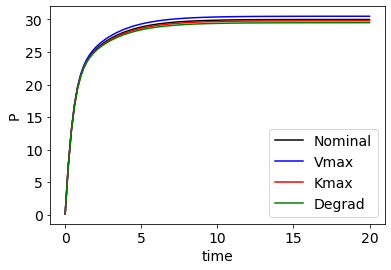

In [ ]:
#@title
# Import the required modules
import numpy as np
import math
import matplotlib.pyplot as plt
# This makes the plots appear inside the notebook
%matplotlib inline

from scipy.integrate import odeint

# Define a function which calculates the derivative
def func(x,t, Vmax, Km, Degradation):    
    S,P = x;
    return [-2*S+0.1*P,Vmax*S/(Km+S)- Degradation * P]


timesteps = np.linspace(0,20,100)
y0 = [5,0.1];

y = odeint(func, y0, timesteps, args = (50,1,1))
y1 = odeint(func, y0, timesteps, args = (50*1.01,1,1))
y2 = odeint(func, y0, timesteps, args = (50,1*1.01,1))
y3 = odeint(func, y0, timesteps, args = (50,1,1*1.01))


# Plot the numerical solution
plt.rcParams.update({'font.size': 14})  # increase the font size
plt.xlabel("time")
plt.ylabel("P")
plt.plot(timesteps, y[:,1],'k', label = "Nominal");
plt.plot(timesteps, y1[:,1],'b', label = "Vmax");
plt.plot(timesteps, y2[:,1],'r', label = "Kmax");
plt.plot(timesteps, y3[:,1],'g', label = "Degrad");
plt.legend()

# PRint the final value of P for our nominal parameter set. This will be needed later.
print(y[-1,1])

# Changing the parameters changes the output
- But the question is: Which parameters are most important for determining the dynamic behavior of (P)roduct?
- This is the heart of sensitivity analysis:
    - To identify the parameters to which the outputs are most sensitive!!

# Sensitivity is one of the more important aspects of computational modeling
- Tells you which interactions are most important
    - E.g. if the model predicts how severe a disease is, then you'd want a drug that targets the most sensitive parameters (interactions)
    - If you're model is very large, you might be able to drop some insensitive components
- Is related to the idea of identifiability
    - Identifiability is simply: can we actually successfully estimate the parameters of our model?
    - Identifiability comes in 2 flavors:
        - Structural identifiability : A model is structurally identifiable if a unique parameterization exists for any given model output. Or in other words, all of the parameters can be estimated if given $\infty$ data....
            - Not super useful
        - Practical identifiability : Can we determine if a parameter value is not zero with a defined, limited amount of data
            - Very useful. 
            - We need to learn some statistics before we get here
    - Regardless, it's pretty straight forward that parameters to which the system is insensitive are difficult or impossible to accurately estimate/identify!

# How to perform sensitivity analyses...the endless debate!

Sensitivity analysis can be done in many ways.
- Local parametric sensitivity: this is what is shown above. You perturb the parameter values by some small percent and then measure the percent change of the output. The sensitivity is the ratio of the % change in the output over the % change in the parameter.
- Local initial condition sensitivity : same as parametric but perturb the initial conditions by some set %.
- "Global" parametric/initial condition sensitivity analysis :  is the process of apportioning the uncertainty in outputs to the uncertainty in each input factor over their entire range of interest

# In the space below, perform a local sensitivity 

- The mathematical definition of local sensitity is $\frac{dx_i}{dk_j}$.
    - As with our error function, we have to consider normalization of each state in the model, $x_i$, and each parameter.
    - Normalized sensitivity is defined as $\frac{dx_i}{dk_j}\frac{k_j}{x_i}$

1. Save your nominal trajectory (i.e. your output with no perturbation). 
2. For each parameter, perturb each parameter up by 1% and simulate the system. Save the outputs.
3. For each parameter, calculate the fractional change in the value of P, relative to the nominal trajectory. Remember that P is product and not parameter
4. Lastly, divide each fractional change in P by the perturbation size such that, for each point in time, you've calculate the change in P over the change in the parameter value.
    - $\frac{P(K*1.01)-P(K)}{P(K)}\frac{K}{K*1.01-K}$

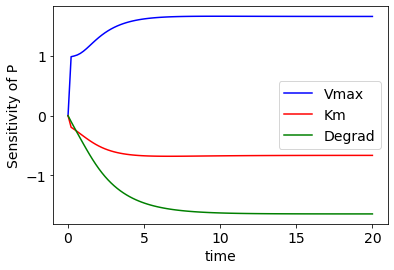

In [ ]:
# Plot the numerical solution
plt.rcParams.update({'font.size': 14})  # increase the font size
plt.xlabel("time")
plt.ylabel("Sensitivity of P")
plt.plot(timesteps, ((y1[:,1] - y[:,1])/y[:,1])/0.01,'b', label = "Vmax");
plt.plot(timesteps, ((y2[:,1] - y[:,1])/y[:,1])/0.01,'r', label = "Km");
plt.plot(timesteps,((y3[:,1] - y[:,1])/y[:,1])/0.01,'g', label = "Degrad");
plt.legend()

# Local sensitivity analysis results
- We find that Vmax is the most important parameter, followed by degradation and Km.
- In larger, more complex models, we often find many parameters with sensitivities near zero!
    - low sensitive interactions may be considered for removal
    - and the parameter value is very hard to estimate when only measuring the model state outputs

# Global sensitivity
- what if our model's behavior changes significantly if we consider bigger perturbations?
- this is where global sensivity attempts to address shortcoming of local sensitivity
    - maybe small perturbations are not meaningful enough!
    

# how to perform global sensitivity analysis (one approach):
   - Perturb the parameters multiple times over a broad range of values. 
     - Should choose a range that is meaningful
   - Run odes for each parameter set, collect output and fit output to a linear model
       - You must decide on the "output". It can be the steadystate value, the maximum over all time, the area under the curve and so on. The decision depends on the question you want to answer.
   - Why a linear model?  
       - If y and k is our nominal output, then our normalized sensivity is $\hat{S} = \frac{\Delta y*k}{\Delta k*y}$. If we multiple both sides by $k/\Delta k$ we get $\frac{\Delta y}{y} = \hat{S}\frac{\Delta k}{k}$.
       - If we have multiple parameters ($k_i$), repeat this process for each parameter, and get $\frac{\Delta y}{y} = \hat{S_1}\frac{\Delta k_1}{k_1} + \hat{S_2}\frac{\Delta k_2}{k_2} + ... + \hat{S_n}\frac{\Delta k_n}{k_n}$  
       - Remembering that everything is known in the above equation except for the values of the sensitivities, $\hat{S_i}$, we have a simple linear model for which we can use least squares regression to estimate $\hat{S_i}$

# Comments on mechanism-based modeling vs "correlation"/empirical modeling
- We are mixing modeling types here and it's important to discuss their differences.
- We have 2 very different types of models with very different limitations and applications
    1. We have an mechanism-based, ODE model probably built using conservation principles and knowledge of how our substrate and product interact.
        1. Models constructed on knowledge/physics/chemical fundamentals often have predictive/extrapolative value
        2. Hence why we love them!
    2. We have a linear model, that has no logical/physical foundations, that we simply fit to data in order to indentify relationships between the data and some select features.
        1. Correlation models or regression models that are constructed without system knowledge are used to characterize, simplify and understand data
            1. Statistics
            2. Machine Learning
- In our global sensivity analysis, we use a linear model to understand how our ode behaves for several sets of parameter values. 

# Global Sensitivity Analysis Step 1: generate data

- We will perform an analysis to identify **which parameters most effect the steadystate value of P**.
- Randomly perturb the parameters of our model by $\pm 20$% and do this 100 times.
    - Let the perturbations be sampled from a uniform distribution. What function could you use?
- Be sure to safe all of the sets of parameters.
- For each set of perturbed parameters, simulate the ODEs. Plot of responses of our state P and save the final value of P for each simulated state trajectory.

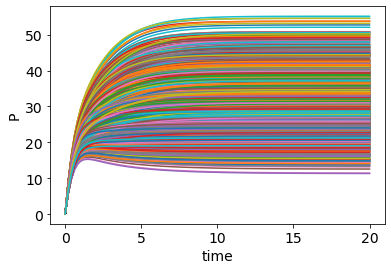

In [ ]:
# generate several output for random selections of parameters
N = 1000;
Vmax = np.random.uniform(50*.8,50*1.2,N);
Km = np.random.uniform(.8,1.2,N);
Degradation = np.random.uniform(.8,1.2,N);

P = np.zeros(N);

for m in np.arange(0,N,1):
    output = odeint(func, y0, timesteps, args = (Vmax[m],Km[m],Degradation[m]));
    plt.plot(timesteps,output[:,1]);
    plt.xlabel("time");
    plt.ylabel("P");
    P[m]=output[-1,1];

# Global Sensitivity Analysis Step 2: visualize your parameter space

- All complex analysis requires baby steps.
- Always visualize each state to make sure your code did what you expected.
- In the space below, plot a histogram of each parameter's value distribution. 
- Are they evenly distributed? Do they go $\pm 20$% of the parameter's nominal value?

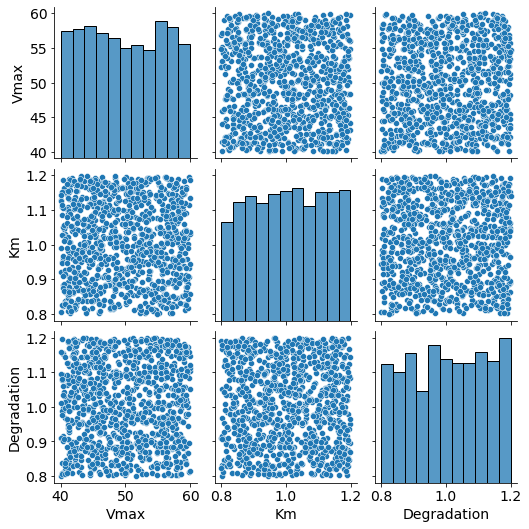

In [ ]:
# Plot histograms of sampled parameter space
import pandas as pd
import seaborn as sns

tmp = {'Vmax':Vmax, 'Km':Km, 'Degradation':Degradation};
df = pd.DataFrame(tmp);
del(tmp)

sns.pairplot(df)  
20
plt.show()

# Global Sensitivity Analysis Step 3: Use least squares to estimate the normalized sensitivities 

- Revisit your least squares regression code for linear systems where the model has **no intercept**
- Which parameter is most important to our output, P?

Our fitted equn is y =  1.6731778442017315 Vmax +  -0.6571206349555128 Km + -1.6828151650394516 Degradation


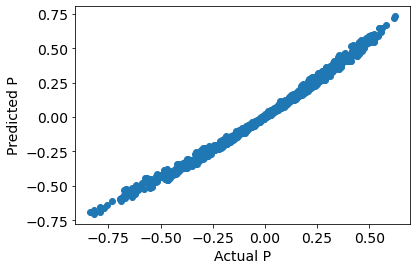

In [ ]:
# Now we have our output of interest, called P. Using our old least squares code, let y = P and normalize the values by
# the value of P's steadystate for the nominal parameter values. This was calculated in step 1 above.

# Normalize y
y = (30-P)/30; # See first set of code to find this number


# Build our X. Normalize values
X = np.c_[(50-Vmax)/50,(1-Km),(1-Degradation)]

# Now can just do the linear least squares estimate
#===================================================

from numpy.linalg import inv
tmp = inv(np.matmul(np.transpose(X),X));

params = tmp @ np.transpose(X) @ y;
print("Our fitted equn is y = ",params[0], "Vmax + ", params[1], "Km +", params[2],"Degradation")

plt.plot(y,X @ params,"o");
plt.ylabel("Predicted P");
plt.xlabel("Actual P");

# # For completeness - let's throw in doing the same thing but with a Linear Regression package. I will show this in class
# # just so we're aware of these packages

# from sklearn.linear_model import LinearRegression
# model = LinearRegression(fit_intercept = False);
# fitted = model.fit(X,y);
# print(fitted.coef_)
# print(fitted.score(X,y)) # R squared

# # Use a different toolbox. R is way better at this...

# import statsmodels.api as sm
# model = sm.OLS(y, X).fit()
# print(model.summary())

# # With interactions
# X = np.c_[(50-Vmax)/50,(1-Km),(1-Degradation),(50-Vmax)/50*(1-Km)]
# model = sm.OLS(y, X).fit()
# print(model.summary())

# Discussion
- Your final equation for the normalized sensitivity should be approximately y = 1.75 Vmax +  -0.68 Km + -1.8 Degradation.
- For our linear model we fit to perturbed outputs (i.e. data) above, the model is only valid for (Vmax, Km, and Degradation) within +/- 20% of the nominal!!
    - Correlation models or empirical models are only valid within the ranges of data that they are trained to
- With normalized parameters, it is much easier to interpret results
- If you run some simulations, you'll see the linear model's predictions are good enough. 

# Discussion continued: Implications
- If we can only measure our concentration of P:
    - Should be easier to estimate Vmax and Degradation than Km
    - If changing Km has only small effect on output, then hard to detect that effect; especially if your data has noise
    - Most effort should focus on Vmax and Degradation in terms of parameterizing the model
- NOTE: This is a very simple global sensitivity analysis. We can make it more complicated by using more complicated lineare regression models that can account for interactions between our parameters
